In [1]:
from build_models import Discriminator,Generator,Adversarial
from Init import Mnist_load
# from CGAN import CGAN

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os  
import math 
from tqdm import tqdm

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow import keras

In [2]:
#파라미터 설정 및 데이터 로드 
data,params,Shape,learning = Mnist_load()
(x_train, y_train)  = data 
(batch_size, latent_size, train_steps, num_labels, model_name) = params
(input_shape,image_size,label_shape) = Shape
(lr,decay) = learning

#input & condition 
image_inputs = Input(shape=input_shape,name = "discriminator_input") #image input 
labels = Input(shape=label_shape,name=  'class_labels') # condition input 

#식별자 모델 
discriminator = Discriminator(image_inputs,labels,image_size).build_dicriminator()
d_optimizer = RMSprop(learning_rate=lr, decay = decay)
discriminator.compile(loss = 'binary_crossentropy',
                        optimizer = d_optimizer,
                        metrics = ['accuracy'])
discriminator.trainable=False

#생성자 모델 
input_shape = (latent_size,)
noise_input = Input(shape=input_shape, name= 'z_input') #noise input 
generator = Generator(noise_input, labels, image_size).build_generator()
g_optimizer = RMSprop(learning_rate=lr*0.5, decay = decay*0.5)

#대립 모델 
adversarial = Adversarial(generator,discriminator,noise_input,labels,g_optimizer).build_adversarial()
adversarial.compile(loss = 'binary_crossentropy',
                    optimizer = g_optimizer,
                    metrics = ['accuracy'])
models = (adversarial,generator,discriminator)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import math 

class CGAN():
    def __init__(self,models,data,params):
        (self.x_train, self.y_train)  = data 
        (self.batch_size, self.latent_size, self.train_steps, self.num_labels, self.model_name) = params
        (self.adversarial,self.generator,self.discriminator) = models
        #학습 중간 확인 용 valid 데이터 
        self.valid_noise_input = np.random.uniform(-1.0,1.0,size=[16,self.latent_size]) #shape = (16,100)
        self.valid_condition = np.eye(self.num_labels)[np.arange(0,16) % self.num_labels] #원 핫 벡터 형태
        #학습 총 데이터 양 
        self.train_size = self.x_train.shape[0] #60000
        self.save_interval =500
        print(self.model_name,"labels for generated images:",np.argmax(self.valid_condition,axis=1)) #원핫인코딩 -> 카테고리컬 인코딩 

    def plot_images(self):
        images = self.generator.predict([self.valid_noise_input,self.valid_condition])
        num_images = images.shape[0] #16
        image_size = images.shape[1] #28

        plt.figure(figsize=(2.2, 2.2))
        rows = int(math.sqrt(self.valid_noise_input.shape[0]))
        for i in range(num_images):
            image = np.reshape(images[i], [image_size, image_size])
            plt.subplot(rows, rows, i + 1)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.show()

    def create_data(self):
        #진짜 데이터 생성 
        rand_indexes = np.random.randint(0,self.train_size,size=self.batch_size)#6만개 중 16개 선택 
        real_images = self.x_train[rand_indexes]
        real_labels = self.y_train[rand_indexes] #진짜 레이블 (조건)

        #가짜 데이터 생성 
        noise = np.random.uniform(-1.0,1.0, size=[self.batch_size,self.latent_size]) #(64,100)형태로 노이즈 만듬
        fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels,self.batch_size)] #가짜 레이블(조건)
        fake_images = self.generator.predict([noise,fake_labels]) #조건 + 노이즈 +생성기 -> 가짜 이미지

        #훈련 데이터 생성 = 진짜 데이터 + 가짜 데이터 
        x = np.concatenate((real_images, fake_images)) #shape = (128,28,28,1)
        condition = np.concatenate((real_labels,fake_labels)) #shape = (128,10) 원핫인코딩라벨 

        y = np.ones([2*self.batch_size,1])
        y[self.batch_size:,:] = 0 #카테고리컬 라벨링 shape = (128,1)
        
        return x,y,condition
        
    def train(self):
        for i in tqdm(range(self.train_steps)):

            """
            discriminator metric
            """
            #평가용 데이터 로드 
            x,y,condition = self.create_data()

            #판별기 네트워크 훈련, 손실과 정확도 기록 
            loss,acc = self.discriminator.train_on_batch([x,condition],y)
            log = "%d : [discriminator loss : %f, acc: %f]" % (i,loss,acc)

            """
            adversarial 
            """
            # 생성자 input 생성 
            noise = np.random.uniform(-1.0,1.0,size = [self.batch_size,self.latent_size]) #noise shape = 64,100
            condition = np.eye(self.num_labels)[np.random.choice(self.num_labels,self.batch_size)] #condition 64,10

            # 생성자 output 생성 
            y = np.ones([self.batch_size,1]) #shape = 64,1

            # 적대적 신경망 학습 및 평가 
            loss,acc = self.adversarial.train_on_batch([noise,condition],y)
            log = "%s [adversarial loss :%f, acc :%f" % (log,loss,acc)
            
            if (i+1) % self.save_interval == 0:
                print(log)
                self.plot_images()
                            
        self.generator.save(f'{self.model_name}.h5')

In [4]:
discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 class_labels (InputLayer)      [(None, 10)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 1024)         11264       ['class_labels[0][0]']           
                                                                                                  
 discriminator_input (InputLaye  [(None, 32, 32, 1)]  0          []                               
 r)                                                                                               
                                                                                                  
 reshape (Reshape)              (None, 32, 32, 1)    0           ['dense[0][0]']      

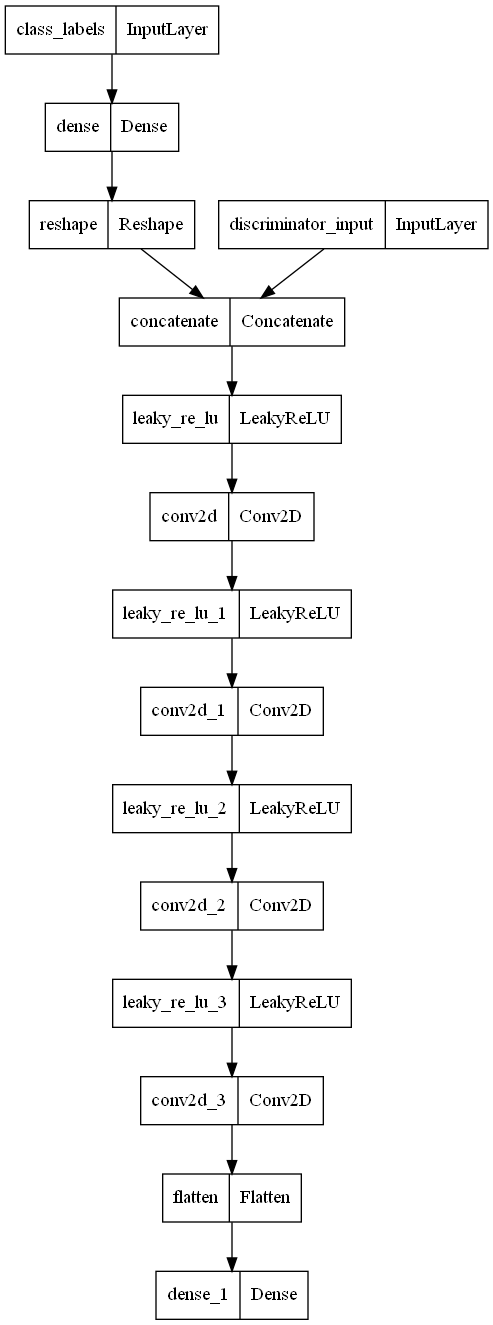

In [6]:
from tensorflow.keras.utils import plot_model 
plot_model(discriminator)

In [9]:
cgan = CGAN(models,data,params)
cgan.train()

cgan_mnist labels for generated images: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]


  1%|          | 258/40000 [00:26<1:09:09,  9.58it/s]


KeyboardInterrupt: 